<a href="https://colab.research.google.com/github/AndromedaSmart/AI-in-Chemistry/blob/main/%22Drug_Design_Master_Class_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ИИ в разработке лекарственных средств: от молекулы к препарату 💊

▶ Центр ИИ в химии | ИТМО | SCAMT

▶ Анастасия Орлова <br>
<br>
Одной из областей применения ИИ в разработке лекарств является предсказание свойств лекарственных молекул (токсичность ☢, биологическая активность 🩸, растворимость 💦 и др.). Применение ИИ для этой задачи позволяет сократить расходы и время на проведение реальных экспериментов в лаборатории. Помимо этого, такой подход также позволяет оценить свойства для новых молекул, которые еще не были синтезированы, а существуют лишь в виде гипотетических формул. <br>
<br>
Данный мастер-класс будет посвящен предсказанию значений **IC50** для лекарств против **COVID-19**. 🦇

## ⚡ Часть 1: Поиск данных

Для того, чтобы научить модель МО предсказывать свойства лекарственных молекул, необходимо предоставить ей **обучающие данные**.

Мы будем искать обучающие данные в [ChEMBL](https://www.ebi.ac.uk/chembl/) - крупнейшей базе данных биоактивных молекул.

Чтобы сделать поиск более удобным, мы будем использовать API ChEMBL.

In [ ]:
! pip install chembl_webresource_client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 575.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
# библиотека для работы с таблицами
import pandas as pd
# ChEMBL API
from chembl_webresource_client.new_client import new_client

При поиске данных мы будем отталкиваться от лекарственной мишени.


> 📌 **Лекарственная мишень** - это макромолекула (чаще всего белок), связанная с конкретным заболеванием. Когда лекарство (**лиганд**) попадает в организм человека, оно находит свою мишень, встраивается в нее и таким образом достигается фармакологический эффект.


Лекарственной мишенью для COVID-19 является белок ***coronavirus 3C-like proteinase***. В норме этот белок отвечает за репликацию РНК вируса, т.е. за его репродукцию. Когда лекарство связывается с этим белком, он "ломается" и перестает выполнять свои функции. Таким образом, вирус больше не может размножаться и со временем погибает.

<img src="https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fsrep25961/MediaObjects/41598_2016_Article_BFsrep25961_Fig1_HTML.jpg" width="400">

Сначала найдем в базе данных все протеиназы.

In [ ]:
target = new_client.target
target_query = target.search('proteinase')
targets = pd.DataFrame.from_dict(target_query)
targets.head(5)

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P06873', 'xref_name': None, 'xre...",Engyodontium album,Proteinase K,14.0,False,CHEMBL1075070,"[{'accession': 'P06873', 'component_descriptio...",SINGLE PROTEIN,37998
1,"[{'xref_id': 'P36400', 'xref_name': None, 'xre...",Leishmania mexicana,Cysteine proteinase B,13.0,False,CHEMBL3821,"[{'accession': 'P36400', 'component_descriptio...",SINGLE PROTEIN,5665
2,"[{'xref_id': 'P0C1U8', 'xref_name': None, 'xre...",Staphylococcus aureus,Glutamyl endopeptidase,13.0,False,CHEMBL5115,"[{'accession': 'P0C1U8', 'component_descriptio...",SINGLE PROTEIN,1280
3,[],Plasmodium falciparum,Trophozoite cysteine proteinase,13.0,False,CHEMBL2366471,"[{'accession': 'P25805', 'component_descriptio...",SINGLE PROTEIN,5833
4,[],Porphyromonas gingivalis,Arg-gingipain-1 proteinase,13.0,False,CHEMBL3308933,"[{'accession': 'Q51816', 'component_descriptio...",SINGLE PROTEIN,837


Найдем нужную нам мишень по ее id.

In [ ]:
covid_data = targets[targets.target_chembl_id=='CHEMBL3927']
covid_data

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
32,"[{'xref_id': 'P0C6U8', 'xref_name': None, 'xre...",SARS coronavirus,SARS coronavirus 3C-like proteinase,9.0,False,CHEMBL3927,"[{'accession': 'P0C6U8', 'component_descriptio...",SINGLE PROTEIN,227859


In [ ]:
selected_target = 'CHEMBL3927'

Далее найдем все лекарственные молекулы, проявляющие активность в отношении coronavirus 3C-like proteinase. Выберем только те молекулы, у которых активность представлена в виде IC50.


> 📌 **IC50 - концентрация полумаксимального ингибирования** - индикатор, который показывает, сколько нужно лиганда—ингибитора для ингибирования биологического процесса на 50 %. Этот показатель обычно используется в качестве индикатора активности вещества в фармакологических исследованиях.

<img src="https://mirams.wordpress.com/wp-content/uploads/2016/06/dose_response.png?w=640" width="400">


In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)
df.head(5)

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,1480935,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,7.2
1,None,None,1480936,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,9.4
2,None,None,1481061,[],CHEMBL830868,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.5
3,None,None,1481065,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,13.11
4,None,None,1481066,[],CHEMBL829584,In vitro inhibitory concentration against SARS...,B,None,None,BAO_0000190,...,SARS coronavirus,SARS coronavirus 3C-like proteinase,227859,None,None,IC50,uM,UO_0000065,None,2.0


In [ ]:
df[['standard_type', 'standard_units', 'standard_value']].head()

,standard_type,standard_units,standard_value
0,IC50,nM,7200.0
1,IC50,nM,9400.0
2,IC50,nM,13500.0
3,IC50,nM,13110.0
4,IC50,nM,2000.0


In [ ]:
df.standard_units.unique()

array(['nM'], dtype=object)

Значения IC50 будут являться в нашем проекте **таргетной величиной**, т.е. величиной, которую мы хотим научиться предсказывать. Все IC50 имеют размерность nM - нано-моль/л.

## ⚡ Часть 2: Обработка данных и расчет дескрипторов для анализа данных

Убираем данные с пропусками в столбце активности:

In [ ]:
df = df[df.standard_value.notna()]
df.shape

(133, 46)

Для удобства анализа данных переведем значения активности в три категории:


*   активные (< 100 nM)
*   средне-активные (100-10000 nM)
*   неактивные (>10000 nM)





In [ ]:
bioactivity_class = []
for i in df.standard_value:
  if float(i) >= 10000:
    bioactivity_class.append("inactive")
  elif float(i) <= 1000:
    bioactivity_class.append("active")
  else:
    bioactivity_class.append("intermediate")
df['bioactivity_class'] = bioactivity_class

Отделим от датасета только самые необходимые колонки, с которыми в дальнейшем будем работать: id молекулы, SMILES молекулы, класс биоактивности, сама биоактивность.

In [ ]:
df = df[['molecule_chembl_id', 'canonical_smiles', 'bioactivity_class', 'standard_value']]
df.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,7200.0
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,9400.0
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,13500.0
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,13110.0
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,2000.0


Чтобы проанализировать имеющиеся молекулы с точки зрения химии, мы рассчитаем для них дескрипторы.

> 📌 **Дескрипторы** - это химические или физико-химические величины, описывающие молекулу. Например, к дескрипторам относятся молекулярная масса, количество атомов углерода, электроотрицательность и т.п.

Так как мы хотим сделать упор на лекарственные свойства молекул, мы рассчитаем **дескрипторы Липински**. В 1997 году Кристофер Липински, ученый из фармацевтической компании Pfizer, придумал правила, позволяющие по структуре молекулы оценить, насколько она является лекарственной.

✋ **Правило пяти Липински (Lipinski Rule of 5):**

*   Молекулярная масса < 500 г/моль
*   Липофильность (LogP) < 5
*   Кол-во доноров водородной связи < 5
*   Кол-во акцепторов водородной связи < 10

Для расчета дескрипторов обычно используют хемоинформатическую библиотеку **RDKit**.




In [ ]:
! pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 36.6 MB/s eta 0:00:00


In [ ]:
# библиотека для хемоинформатики
from rdkit import Chem
from rdkit.Chem import Descriptors

In [ ]:
df['MW'] = df.canonical_smiles.apply(lambda x: Descriptors.MolWt(Chem.MolFromSmiles(x)))
df['LogP'] = df.canonical_smiles.apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))
df['NumHDonors'] = df.canonical_smiles.apply(lambda x: Descriptors.NumHDonors(Chem.MolFromSmiles(x)))
df['NumHAcceptors'] = df.canonical_smiles.apply(lambda x: Descriptors.NumHAcceptors(Chem.MolFromSmiles(x)))

In [ ]:
df

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL187579,Cc1noc(C)c1CN1C(=O)C(=O)c2cc(C#N)ccc21,intermediate,7200.0,281.271,1.89262,0,5
1,CHEMBL188487,O=C1C(=O)N(Cc2ccc(F)cc2Cl)c2ccc(I)cc21,intermediate,9400.0,415.589,3.81320,0,2
2,CHEMBL185698,O=C1C(=O)N(CC2COc3ccccc3O2)c2ccc(I)cc21,inactive,13500.0,421.190,2.66050,0,4
3,CHEMBL426082,O=C1C(=O)N(Cc2cc3ccccc3s2)c2ccccc21,inactive,13110.0,293.347,3.63080,0,3
4,CHEMBL187717,O=C1C(=O)N(Cc2cc3ccccc3s2)c2c1cccc2[N+](=O)[O-],intermediate,2000.0,338.344,3.53900,0,5
...,...,...,...,...,...,...,...,...
128,CHEMBL2146517,COC(=O)[C@@]1(C)CCCc2c1ccc1c2C(=O)C(=O)c2c(C)c...,inactive,10600.0,338.359,3.40102,0,5
129,CHEMBL187460,C[C@H]1COC2=C1C(=O)C(=O)c1c2ccc2c1CCCC2(C)C,inactive,10100.0,296.366,3.44330,0,3
130,CHEMBL363535,Cc1coc2c1C(=O)C(=O)c1c-2ccc2c(C)cccc12,inactive,11500.0,276.291,4.09564,0,3
131,CHEMBL227075,Cc1cccc2c3c(ccc12)C1=C(C(=O)C3=O)[C@@H](C)CO1,inactive,10700.0,278.307,3.29102,0,3


Для модели машинного обучения важно, чтобы распределение таргетной величины было как можно ближе к нормальному. При таком распределении выборка считается репрезентативной и модель может наилучшим образом предсказывать новые значения из этой выборки.

<img src="https://radioprog.ru/uploads/media/articles/0001/05/40ac327b7a20b39132ad3abe5d9cf45fd6ad6763.jpeg" width="400">

Чтобы приблизить наши данные к нормаьному распределению, мы переведем значения IC50 в отрицательную логарифмическую шкалу (-log10, обозначается как *p*).

In [ ]:
# библиотека для математических операций
import numpy as np

В исходном датасете значения IC50 были представлены в виде текста, переведем их в числовой формат.

In [ ]:
df['standard_value'] = pd.to_numeric(df['standard_value'])

Посмотрим распределение IC50 в исходном датасете. Видно, что значения смещены влево, распределение далеко от нормального.

<Axes: >

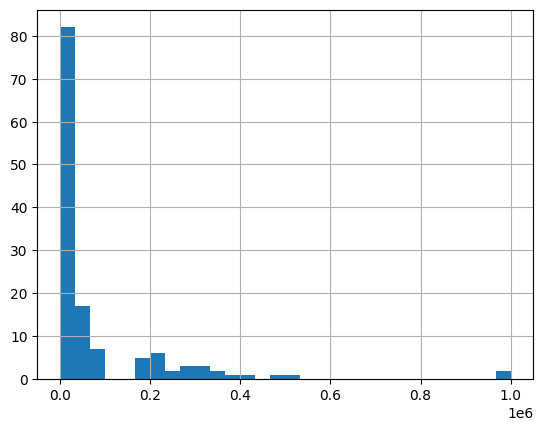

In [ ]:
df.standard_value.hist(bins=30)

In [ ]:
def normalize(x):
  """This function converts nM into M and applies negative logarithmic scale"""
  molar = x*(10**-9)
  pIC50 = -np.log10(molar)
  return pIC50

Значения выше 100 млн моль/л зафиксируем на 100 млн моль/л, т.к. иначе при логарифмировании они станут отрицательными.

In [ ]:
print(-np.log10((10**-9)* 100000000))
print(-np.log10((10**-9)* 10000000000))

1.0
-1.0


In [ ]:
def skip(x):
  """This function fixes values greater than 100,000,000 at 100,000,000"""
  if x > 100000000:
    return 100000000
  else:
    return x

In [ ]:
df['pIC50'] = df.standard_value.apply(skip)
df['pIC50'] = df.standard_value.apply(normalize)

Посмотрим распределение после преобразований. Видим, что оно стало близким к нормальному.

<Axes: >

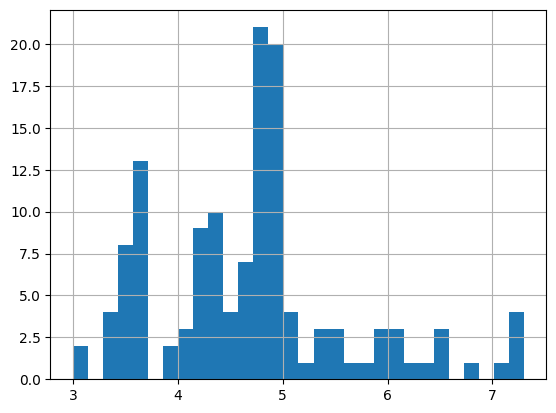

In [ ]:
df.pIC50.hist(bins=30)

## ⚡ Часть 3: Анализ данных

Перед тем, как обучать модель, надо понять, с какими данными мы вообще имеем дело. Для этого на помощь приходит визуализация данных.

In [ ]:
# библиотеки для рисования графиков
import matplotlib.pyplot as plt
import seaborn as sns

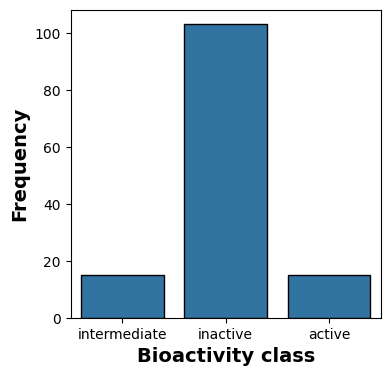

In [ ]:
plt.figure(figsize=(4, 4))

sns.countplot(x='bioactivity_class', data=df, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.show()

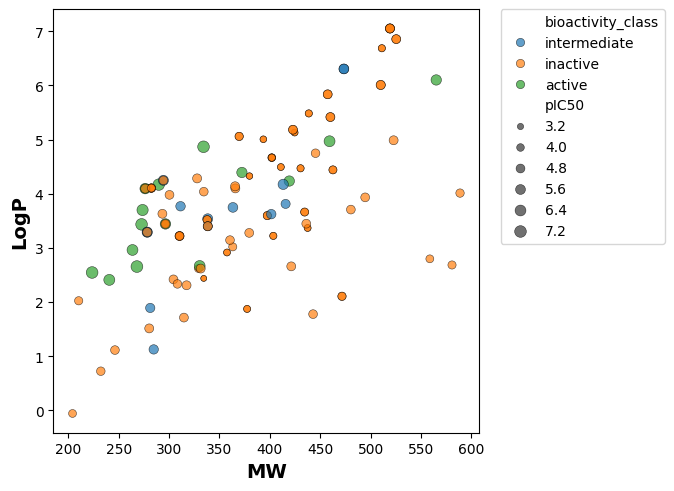

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

Еще один часто используемый способ визуализации данных - это **Boxplot (Ящик с усами)**.
Более подробно [здесь](https://youtube.com/shorts/xkzsxmZfpZw?feature=shared).

<img src="https://i.stack.imgur.com/DEgpx.png" width="600">

Text(0, 0.5, 'MW')

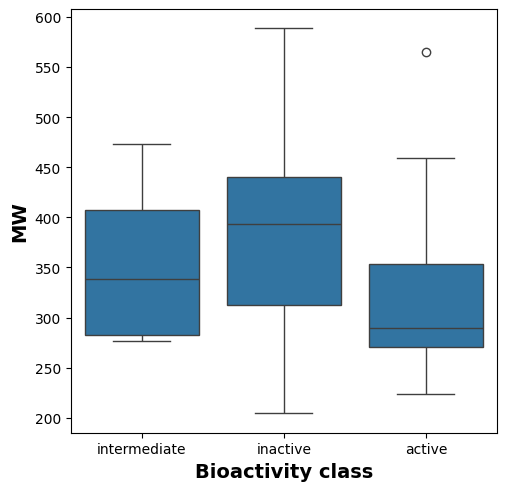

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='MW', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

Text(0, 0.5, 'LogP')

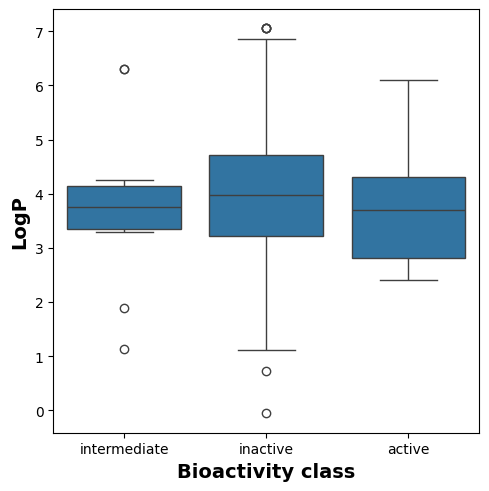

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='LogP', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

Text(0, 0.5, 'NumHDonors')

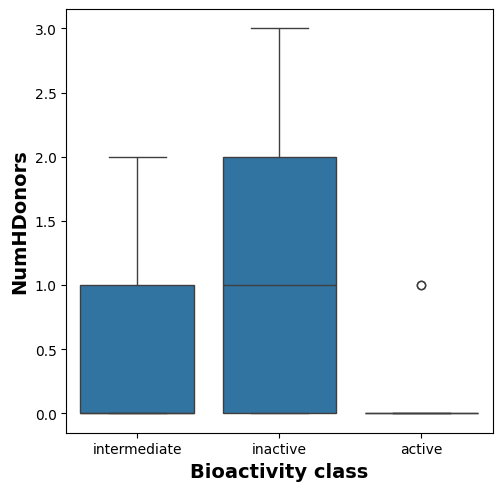

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHDonors', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

Text(0, 0.5, 'NumHAcceptors')

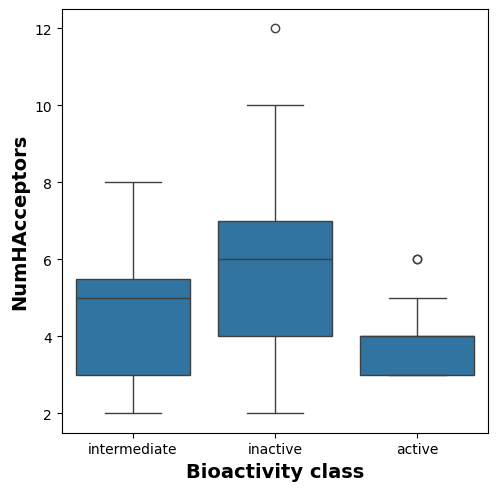

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='bioactivity_class', y='NumHAcceptors', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

С помощью библиотеки RDKit можно также визуализировать сами молекулы.

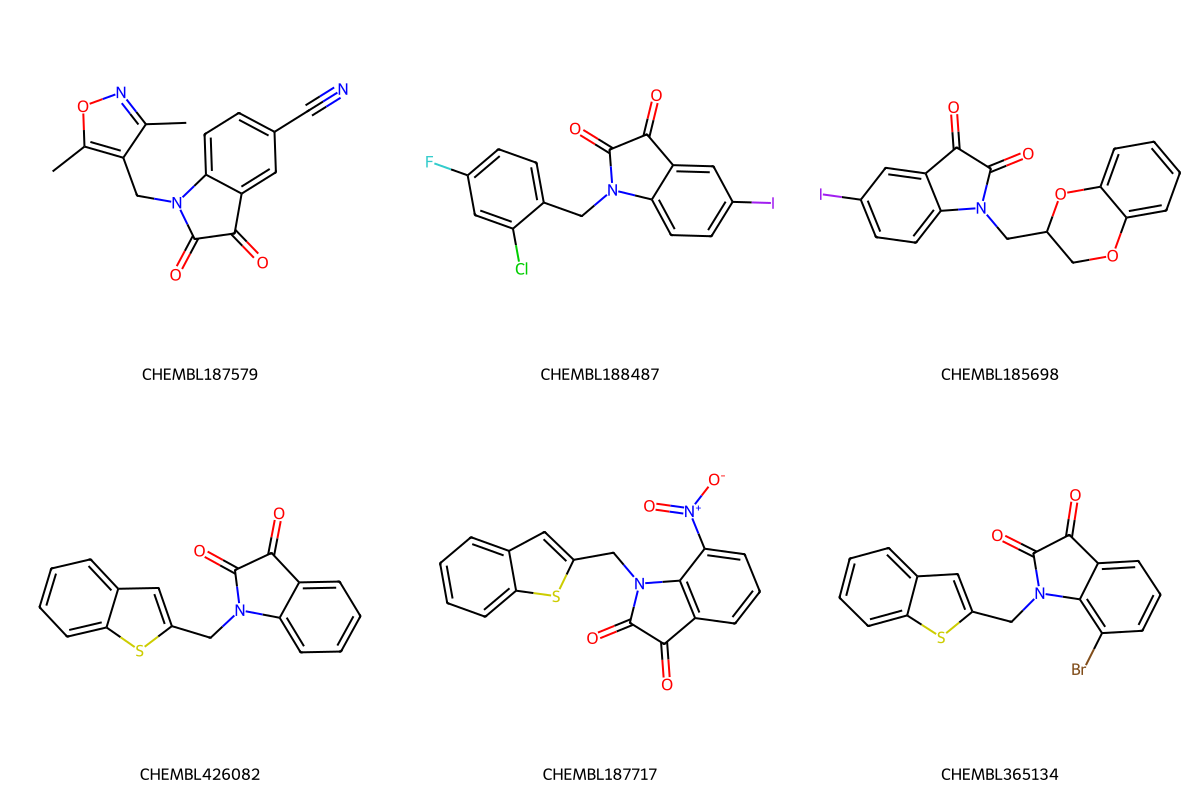

In [ ]:
mols = [Chem.MolFromSmiles(smi) for smi in df.canonical_smiles][:6]
ids = df.molecule_chembl_id.tolist()[:6]
Chem.Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(400, 400), legends=ids)

## ⚡ Часть 4: Расчет дескрипторов для обучения модели МО

Мы хотим научить модель предсказывать IC50 по структуре молекулы. Но модель - это по сути набор математических операций, и формат SMILES ей будет не понятен. Дескрипторов Липински недостаточно, т.к. они не полностью описывают молекулы.Поэтому мы переведем наши молекулы в числовой вид с помощью **фингерпринтов**.



> 📌 **Фингерпринты** (или молекулярные отпечатки пальцев) - это способ представления структуры молекулы в виде бинарной строки.

<img src="https://www.mdpi.com/molecules/molecules-27-02331/article_deploy/html/images/molecules-27-02331-g001.png" width="400">



In [ ]:
# дополнительные модули из RDKit
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray

In [ ]:
def get_fp(x):
  """This function converts molecular SMILES into fingerprints"""
  fp_array = np.zeros((0,), dtype=np.int8)
  mol = Chem.MolFromSmiles(x)
  fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=256)
  ConvertToNumpyArray(fp, fp_array)
  return fp_array

In [ ]:
fingerprints = []
for smiles in df.canonical_smiles.tolist():
  fp = get_fp(smiles)
  fingerprints.append(fp)

In [ ]:
fingerprints[0]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=int8)

## ⚡ Часть 5: Обучение модели МО

Сначала необходимо определить X (обучающие признаки) и y (таргетная величина). В нашем случае X - это фингерпринты молекул, а y - значения pIC50.

In [ ]:
X = np.array(fingerprints)
y = df.pIC50

Далее нужно разделить данные на **тренировочную** и **тестовую** выборки. На тренировочной выборке модель учится сопоставлять структуры молекул и их IC50, а тестовую выборку модель никогда не видела и на ней мы будем проверять, как модель научилась предсказывать. Обычно для тренировочной выборк берут 80% данных, а для тестовой - 20%.

In [ ]:
# библиотека для машинного обучения
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Существует большое количество разных моделей МО. Все они основаны на различных математических опреациях и могут проявлять себя по-разному в зависимости от данных. Поэтому необходимо сначала подобрать самую эффективную модель для нашей конкретной задачи.

In [ ]:
# библиотека для сравнения разных моделей МО
! pip install lazypredict

In [ ]:
import lazypredict
from lazypredict.Supervised import LazyRegressor

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:12<00:00,  3.30it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 225
[LightGBM] [Info] Number of data points in the train set: 106, number of used features: 75
[LightGBM] [Info] Start training from score 4.736293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

Выведем результаты. Видно, что некоторые модели справились очень плохо (например, Lars, LinearRegression), а некоторые показали себя довольно неплохо. Самыми лучшими оказались GradientBoostingRegressor и AdaBoostRegressor.

In [ ]:
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
Lars,15959954834029643311936163017415002390218229694...,-1411842158394929876037627270940579110615032272...,32977111553672271395883790500868950593092964534...,0.38
LinearRegression,7725107311687464174747648.00,-68337487757235263228608512.00,7255194253451.34,0.07
TransformedTargetRegressor,7725107311687464174747648.00,-68337487757235263228608512.00,7255194253451.34,0.20
KernelRidge,4.40,-29.04,4.81,0.04
GaussianProcessRegressor,2.58,-12.98,3.28,0.06
MLPRegressor,1.17,-0.53,1.09,0.51
DummyRegressor,1.11,-0.01,0.88,0.03
LassoLars,1.11,-0.01,0.88,0.03
Lasso,1.11,-0.01,0.88,0.03


**AdaBoost** - это модель машинного обучения, основанная на ансамбле
классификаторов: каждый следующий классификатор строится по объектам, неверно классифицированным предыдущим.

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRoWJTpRIPogLZBQDMs06lQD_BZwAaEPRHleg&s" width=400>

Далее будем работать только с AdaBoostRegressor. Обучим модель и предскажем значения pIC50 для тестовой выборки, чтобы оценить насколько хорошо справилась модель. Посчитаем коэффициент детерминации R2.

> Чем ближе R2 к 1, тем лучше научилась модель.



In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score

In [ ]:
regr = AdaBoostRegressor(random_state=42)
regr.fit(X_train, y_train)
y_test_pred = regr.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print(f'R2 test: {r2_test}')

R2 test: 0.6681116369766452


Необходимо также посчитать коэффициент детерминации для тренировочной выборки. Это нужно для того, чтобы понять, не переобучилась ли модель.

> 📌 **Переобучение** - явление, когда построенная модель хорошо объясняет примеры из обучающей выборки, но относительно плохо работает на примерах, не участвовавших в обучении (на примерах из тестовой выборки).

Это связано с тем, что при построении модели («в процессе обучения») в обучающей выборке обнаруживаются некоторые случайные закономерности, которые отсутствуют в генеральной совокупности.

Иными словами, модель запоминает огромное количество всех возможных примеров вместо того, чтобы научиться подмечать особенности.



In [ ]:
y_train_pred = regr.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f'R2 train: {r2_train}')

R2 train: 0.8476255875524427


В нашем случае модель не переобучилась, т.к. R2 на тренировочной и тестовой выборках сопоставимы друг с другом.
Чтобы визуально оценить качество модели, можно также нарисовать графики зависимости предсказанной величины от экспериментальной.

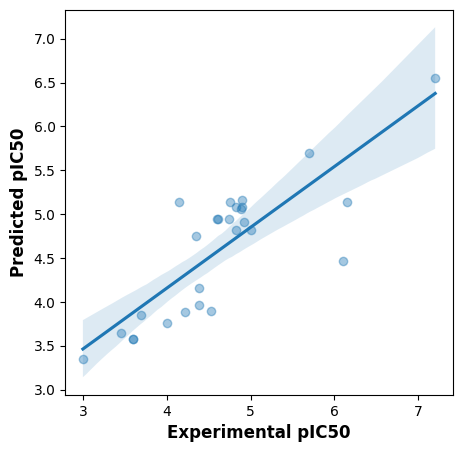

In [ ]:
ax = sns.regplot(x=y_test, y=y_test_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.figure.set_size_inches(5, 5)
plt.show()

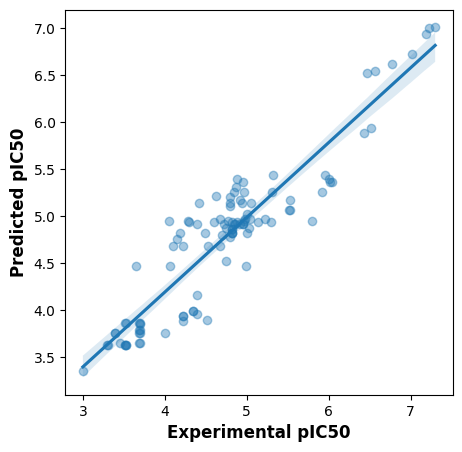

In [ ]:
ax = sns.regplot(x=y_train, y=y_train_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.figure.set_size_inches(5, 5)
plt.show()

Чтобы улучшить качество модели, можно **оптимизировать ее параметры**. Возможные параметры модели, а также значения параметров по умолчанию можно найти в документации библиотеки scikit-learn. Например, информация об AdaBoostRegressor находится [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html).

In [ ]:
regr = AdaBoostRegressor(n_estimators=100, random_state=42)
regr.fit(X_train, y_train)

y_test_pred = regr.predict(X_test)
r2_test = r2_score(y_test, y_test_pred)
print(f'R2 test: {r2_test}')

y_train_pred = regr.predict(X_train)
r2_train = r2_score(y_train, y_train_pred)
print(f'R2 train: {r2_train}')

R2 test: 0.6856003889742479
R2 train: 0.8457592753454272
